
# tl;dr: 

- piled on linearity does not change modeling capacity
- how non linearity aides here



In [1]:
import time
import torch
import matplotlib.pyplot as plt
from typing import Callable, Type

torch.manual_seed(42)

# Helpers

We want to focus on principles, not iterate over stuff we've already done.

In case you're curious, there are two helpers:

- visualize dataset
- train (a function that takes model and data and just ... trains it. Stupid and simple.)

In [2]:
# Training loop function
from IPython.display import clear_output, display

def visualize_dataset(X: torch.Tensor, Y: torch.Tensor, name: str = ''):
    plt.figure(figsize=(3, 3), dpi=150)
    plt.scatter(X.detach().numpy(), Y.detach().numpy(), s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(name)
    plt.show()

def scale_labels(y: torch.Tensor) -> torch.Tensor:
    """Scales a tensor between 0 and 1. Expects the shape (n, 1)"""
    return (y - y.min()) / (y.max() - y.min()) 
    
%matplotlib inline
def train(
        model: torch.nn.Module,
          X: torch.Tensor, 
          Y: torch.Tensor,
          loss_function: Callable = torch.nn.MSELoss(), 
          optimizer_class: Type = torch.optim.SGD,
          epochs: int = 200,
          learning_rate: float = 0.01,
          sleep_time: int | None = None,
          early_stopping_threshold: float = 0.002,
          viz_every: int = 1
          ) -> torch.nn.Module:
    
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    losses = []
    
    for epoch in range(epochs+1):

        # Do a train step
        # # Everything else is just 'fluff'
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = loss_function(Y_pred, Y)
        loss.backward()
        optimizer.step()
        
        # Visuzlie every n times
        if epoch % viz_every == 0:
            # Live visualization
            clear_output(wait=True)
            plt.figure(figsize=(6,4), dpi=100)

            # Plot real data
            plt.scatter(X.numpy(), Y.numpy(), alpha=0.3, label='Data')
            # Plot model predictions
            with torch.no_grad():
                X_pred = model(X)
            plt.plot(X.numpy(), Y_pred.detach().numpy(), 'r-', label='Model Prediction')

            plt.title(f"Epoch: {epoch}, Loss={loss.item():.4f}")
            plt.legend()
            plt.show()

        # Early stopping
        if loss.item() < early_stopping_threshold:
            print(f"Converged at epoch {epoch}")
            break
        
        if sleep_time is not None:
            time.sleep(sleep_time)

        # Log results
        losses.append(loss.item())

    # Visualize loss
    plt.figure(figsize=(4,4), dpi=150)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.show()

    return model

## Defining a problem

In [ ]:
# Data generation constants
n_samples = 1_000
noise_scale = 0.05

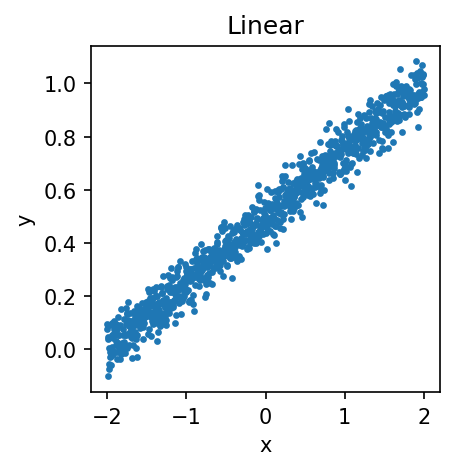

torch.Size([1000, 1]) torch.Size([1000, 1])


In [4]:
# Linear dataset: y = 10x + 2
X_lin = torch.linspace(-2, 2, n_samples).unsqueeze(1)
Y_lin = 10*X_lin + 2
Y_lin = scale_labels(Y_lin)
Y_lin += torch.randn(n_samples,1) * noise_scale

visualize_dataset(X_lin, Y_lin, "Linear")
print(X_lin.shape, Y_lin.shape)

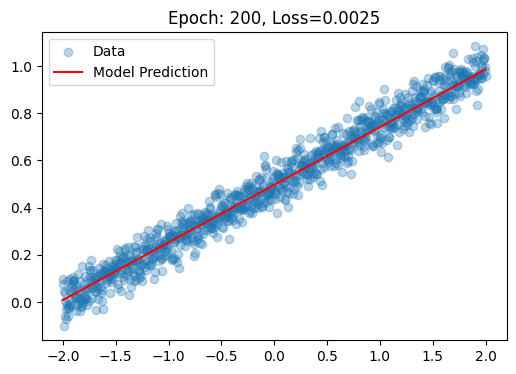

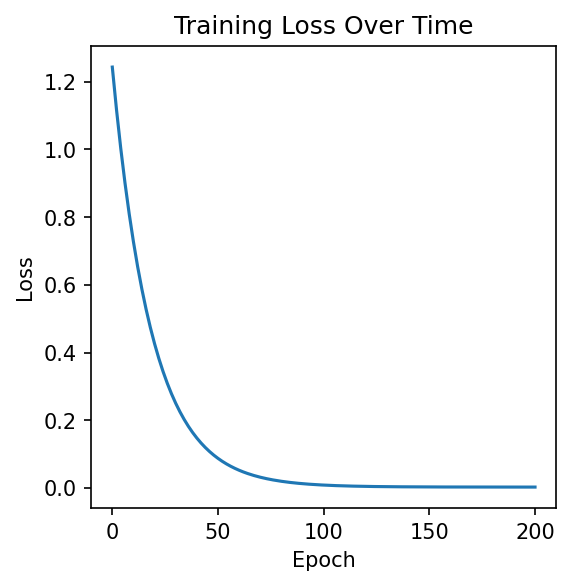

LinReg(
  (layer_1): Linear(in_features=1, out_features=1, bias=True)
)

In [5]:
# Lets try a linear model to solve it
class LinReg(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(1, 1)
    
    def forward(self, x):
        return self.layer_1(x)
    
train(model=LinReg(), X=X_lin, Y=Y_lin, early_stopping_threshold=0.001)

# Step 2. Lets make a more difficult problem

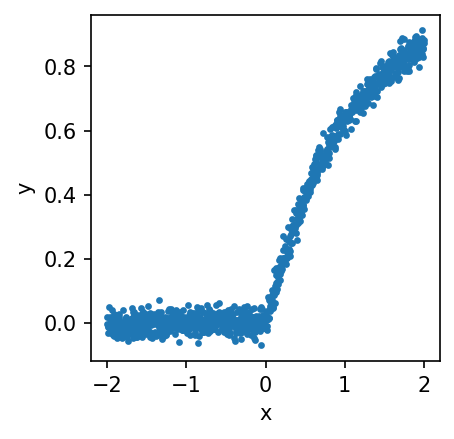

In [8]:
# Define the piecewise continuous function:
#    y(x) = 0           if x < 0
#           1 - e^{-x}  if x >= 0
def piecewise_fn(x):
    return torch.where(
        x < 0,
        torch.zeros_like(x),
        1.0 - torch.exp(-x)
    )

X_pcf = torch.linspace(-2, 2, n_samples).unsqueeze(1)
Y_pcf = piecewise_fn(X_pcf)
Y_pcf += torch.randn(n_samples, 1) * noise_scale/2

# Note to self: see with and without the noise
visualize_dataset(X_pcf, Y_pcf)

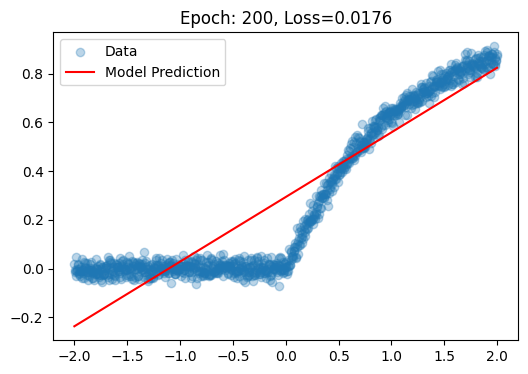

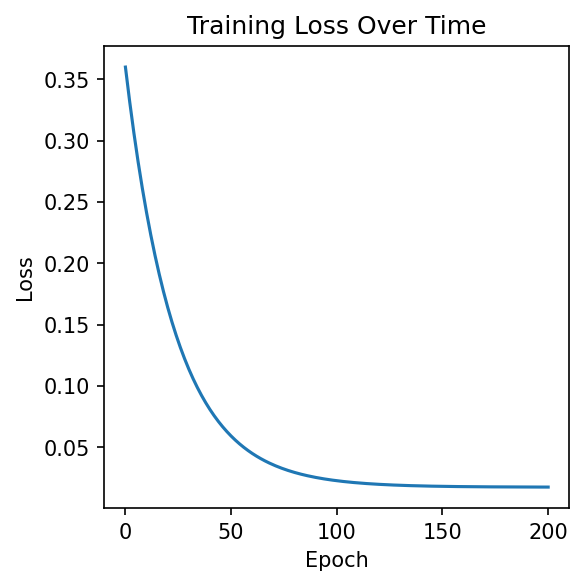

LinReg(
  (layer_1): Linear(in_features=1, out_features=1, bias=True)
)

In [9]:
# Can we just fit our linear model?
train(LinReg(), X_pcf, Y_pcf, viz_every=10)

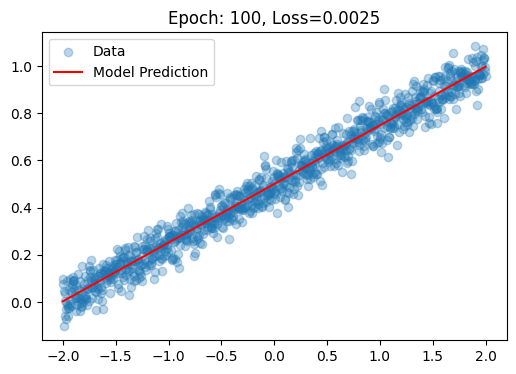

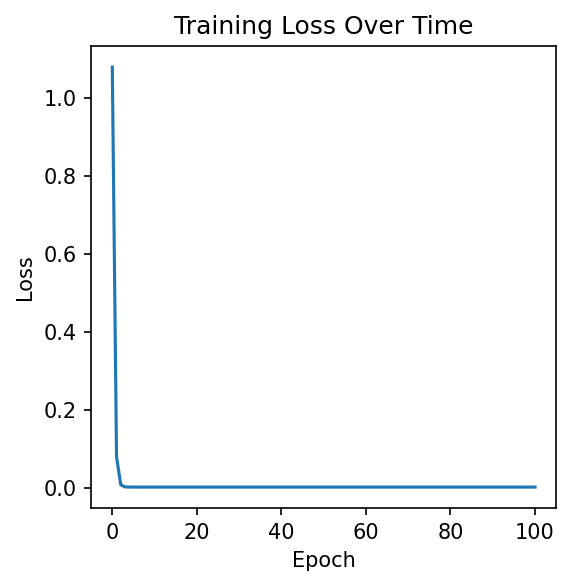

BigLinReg(
  (layer_1): Linear(in_features=1, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=1, bias=True)
)

In [11]:
# Just increasing parameters?
# Lets try a linear model to solve it
class BigLinReg(torch.nn.Module):
    def __init__(self, n_features: int=1):
        super().__init__()
        self.layer_1 = torch.nn.Linear(n_features, 100)
        self.layer_2 = torch.nn.Linear(100, 1)

    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
    
# This gets done in around 5 epochs
train(model=BigLinReg(), X=X_lin, Y=Y_lin, epochs=100)


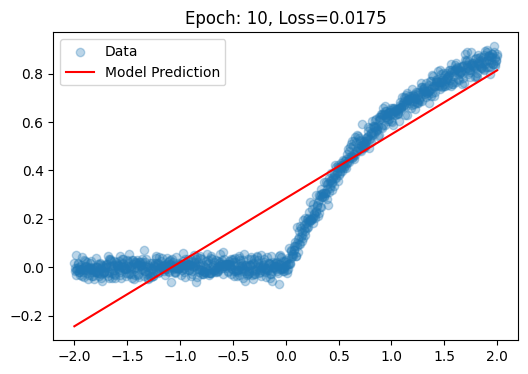

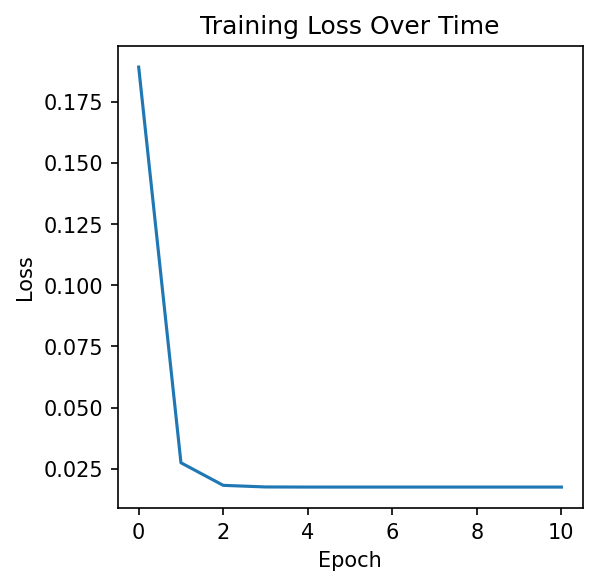

BigLinReg(
  (layer_1): Linear(in_features=1, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=1, bias=True)
)

In [12]:
# But can it fit the squared thing?
train(BigLinReg(), X_pcf, Y_pcf, epochs=10)

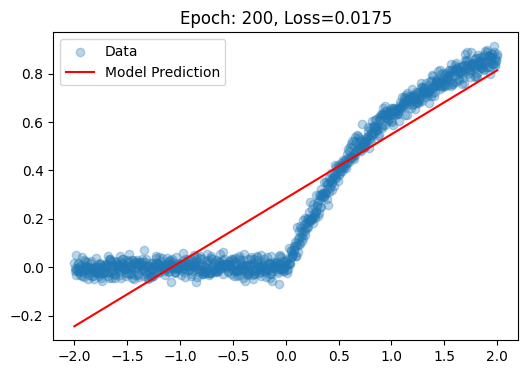

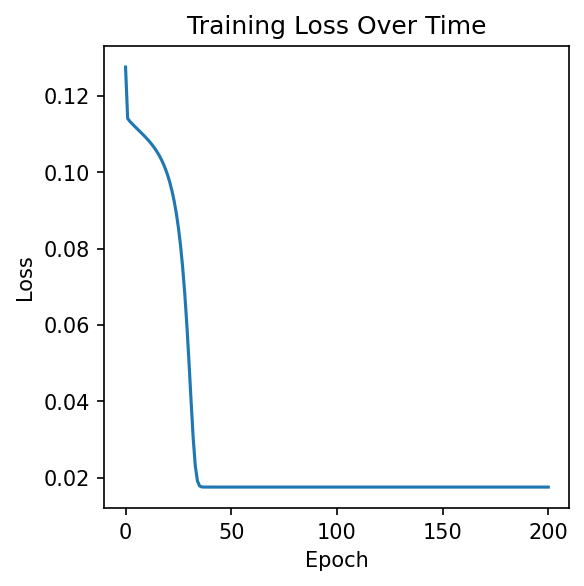

LinRegCustom(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [13]:
# How about adding five different layers
class LinRegCustom(torch.nn.Module):

    def __init__(self, n_layers=5, hidden_dim=100):
        super().__init__()
        layers = [torch.nn.Linear(1, hidden_dim)]
        for _ in range(n_layers - 2):
            layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
        layers.append(torch.nn.Linear(hidden_dim, 1))
        print(layers)
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
train(LinRegCustom(10, 20), X_pcf, Y_pcf, viz_every=10, learning_rate=0.2)

## Why is that?


### Why can a model with 1000 parameters not fit slightly more complex things?

### What happens when we compose a linear function?

### Wait, what is function composition?

$$ f \odot g := f(g(x)) $$ 

E.g. if $f$ is increase by one i.e., $f(x) = x + 1$, and $g$ is double it i.e., $g(x) = 2x$, the composition $ f \odot g$ will be:

$$
\begin{equation}
\begin{split}
f \odot g (x) &:= f(g(x)) \\
 &= f(2x) \\
 &= 2x + 1
\end{split}
\end{equation}
$$

### Ok, lets recall what a linear function is, again


$$ f(x) = \omega_1 x + \omega_0$$

Let $f(x)$ be the first layer of our model. Let $g(x)$ be the second layer:

$$ g(x) = \omega_3 x + \omega_2$$


Now lets try to compose them:

$$ \begin{equation}
\begin{split}
f \odot g (x) &:= f(g(x)) \\
&= f(\omega_3 x + \omega_2) \\
&= \omega_1 (\omega_3 x + \omega_2) + \omega_0 \\
&= \omega_1 \omega_3 x + \omega_1 \omega_2 + \omega_0 \\
&= (\omega_1 \omega_3) x + (\omega_1 \omega_2 + \omega_0)
\end{split}
\end{equation}
$$

If we were to define a new constant number $\omega_4 = \omega_1 \omega_3$ and $\omega_5 = \omega_1 \omega_2 + \omega_0$, we can get:

$$ f \odot g (x) = \omega_4 x + \omega_5 $$

That is, **composing two (or more) linear functions will lead to another linear function!!**


# Activation functions

So what can we do to model more complex things (:= have a larger modeling capacity)?

If composing a linear with a linear leads to a linear, what if we throw something non linear in there?

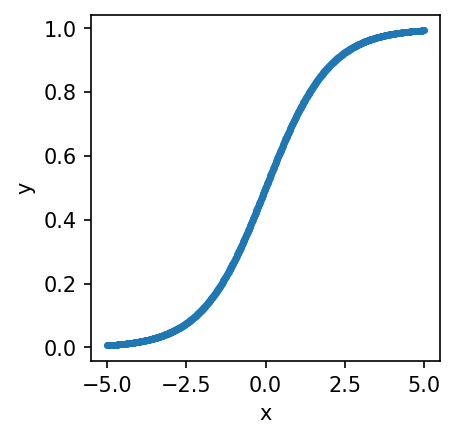

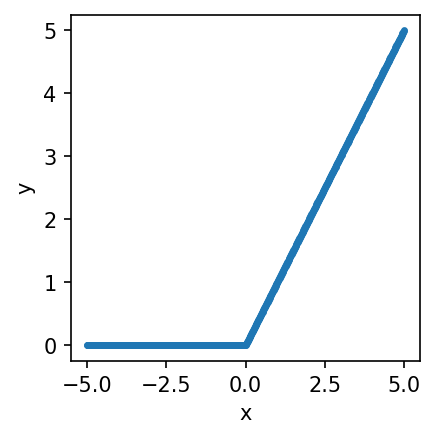

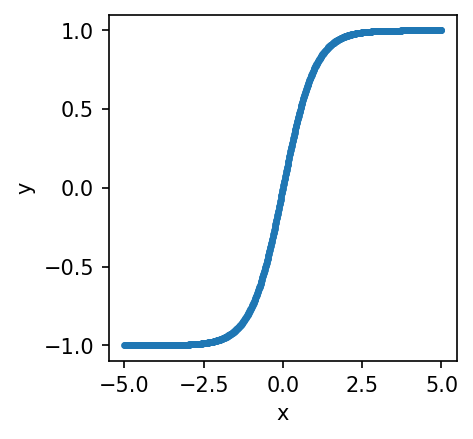

In [19]:
# Introducing 'activation functions'
X = torch.linspace(-5, 5, n_samples).unsqueeze(1)
visualize_dataset(X, torch.sigmoid(X))
visualize_dataset(X, torch.relu(X))
visualize_dataset(X, torch.tanh(X))

## Sigmoid

A sigmoid function (first plot above) can be defined as:

$$ sigmoid(x) = \frac{1}{1+ e^{-x}} $$

Its' got some nice properties (and a very easy and efficient derivate) but we dont worry about it for now. 
Let's see what happens if we compose our two linear layers with a sigmoid in the middle.

Recall that

$$ 
\begin{equation}
\begin{split} 
f(x) &= \omega_1 x + \omega_0 \\ 
g(x) &= \omega_3 x + \omega_2 
\end{split}\end{equation}$$

$$
\begin{equation}
\begin{split}
f \odot sigmoid \odot g (x) 
&:= f\bigl(\sigma(g(x))\bigr) \\
&= f\Bigl(\sigma\bigl(\omega_3 x + \omega_2\bigr)\Bigr) \\
&= \omega_1 \cdot \sigma\bigl(\omega_3 x + \omega_2\bigr) + \omega_0 \\
&= \omega_1 \cdot \frac{1}{1 + e^{-\bigl(\omega_3 x + \omega_2\bigr)}} + \omega_0 
\end{split}
\end{equation}
$$

Because of the **sigmoid** in the middle, this no longer simplifies to a single linear function in \(x\). That “bend” introduced by the sigmoid is what gives our model a richer capacity to learn more complex patterns.

As you can see, it looks complex but importantly **its not linear**!! Now lets put it in practice.

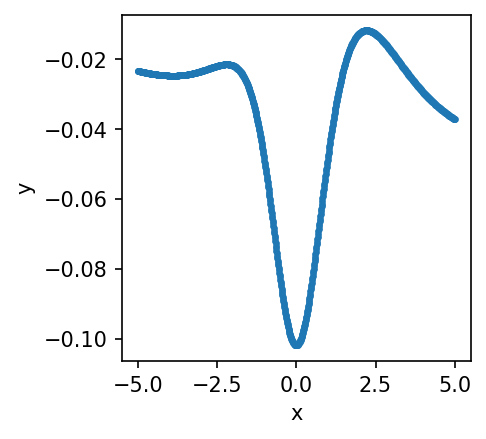

In [93]:
# With a sigmoid activation

class ActLinReg(torch.nn.Module):

    def __init__(self, act_fn: Callable=torch.sigmoid):
        super().__init__()
        self.input_layer = torch.nn.Linear(1, 10)
        self.hidden_layer = torch.nn.Linear(10, 10)
        self.output_layer = torch.nn.Linear(10, 1)
        self.act_fn = act_fn

    def forward(self, x):
        x = self.act_fn(self.input_layer(x))
        x = self.act_fn(self.hidden_layer(x))
        return self.output_layer(x)

# Visualize a couple times with ReLU and Sigmoid
visualize_dataset(X, ActLinReg(torch.tanh)(X), '')

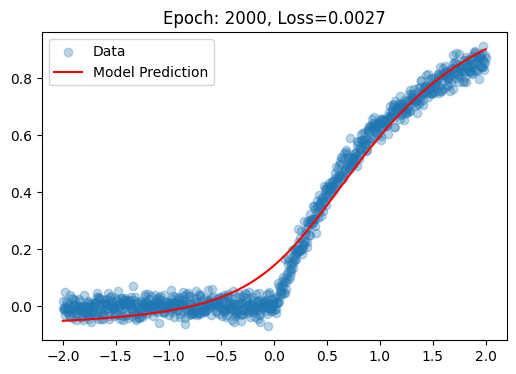

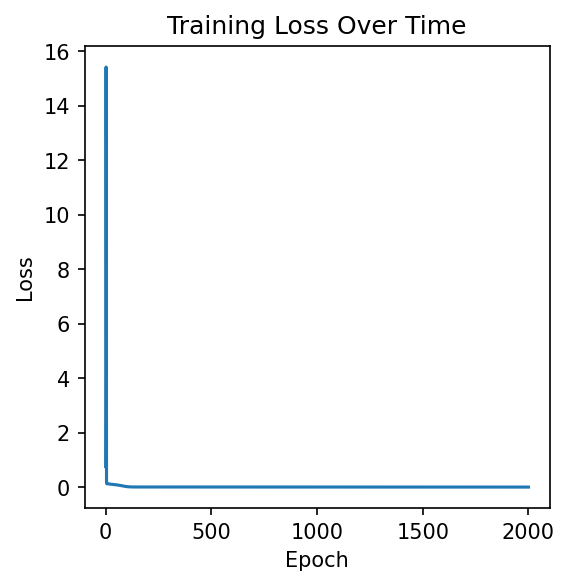

ActLinReg(
  (input_layer): Linear(in_features=1, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [94]:
train(ActLinReg(), X_pcf, Y_pcf, learning_rate=0.5, viz_every=100, epochs=2000, early_stopping_threshold=0.0005)

## Lets crank the difficulty up a notch

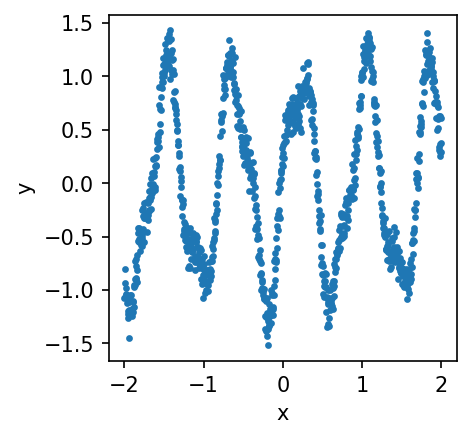

In [97]:
# A wavy function in 1D
def wavy_fn(x):
    # shape: (n_samples, 1)
    return torch.sin(3 * x) + 0.3 * torch.cos(7 * x)

# Make a dataset: X in [-2, 2]
X_wav = torch.linspace(-2, 2, n_samples).reshape(-1, 1)
Y_wav = wavy_fn(X)
Y_wav += torch.randn(n_samples, 1) * noise_scale*2
visualize_dataset(X_wav, Y_wav)

## Note to self (Priyansh ^^)
- Try with sigmoid

- Then try with ReLU

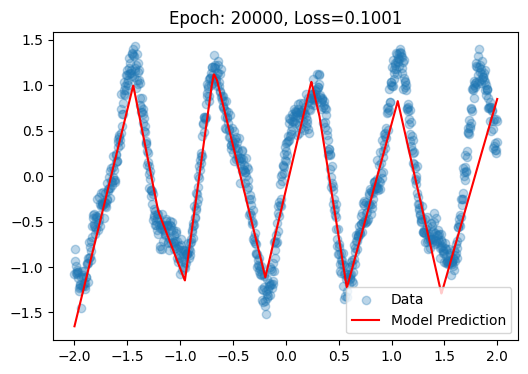

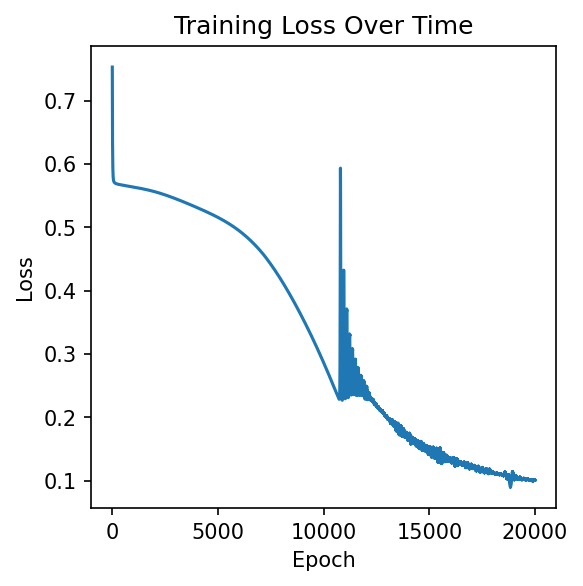

ActLinReg(
  (input_layer): Linear(in_features=1, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In [99]:
train(ActLinReg(torch.relu), X_wav, Y_wav, viz_every=100, learning_rate=0.01, epochs=20000)

# Conclusion

Adding non linearity between linear layers makes our model much much more powerful.

**now you have all the 'core concepts' that make up 'deep learning':

- Loss is our 'objective', our 'goal'
- Gradient descent as a way to optimize to achieve the goal
- Forward propagation of inputs, back propagation of gradients
- Compising non linear + linear parts to increase modeling capacity

# Further Reading

or **home work**

In [101]:
# Define a Multi-Layer Perceptron (MLP) class
class MLP(torch.nn.Module):
    def __init__(self, n_hidden_layers: int = 5, act_fn: torch.nn.Module = torch.nn.ReLU, hidden_dim: int = 10):
        super().__init__()
        # Define the input layer
        input_layer = torch.nn.Linear(1, hidden_dim)
        
        # Define the hidden layers with activation functions
        hidden_layers = [act_fn()]  # Activation over the input layer
        for _ in range(n_hidden_layers):
            hidden_layers += [torch.nn.Linear(hidden_dim, hidden_dim), act_fn()]
        
        # Define the output layer
        output_layer = torch.nn.Linear(hidden_dim, 1)

        # Combine all layers into a sequential model
        self.layers = torch.nn.Sequential(input_layer, *hidden_layers, output_layer)

    def forward(self, x):
        return self.layers(x)

# Instantiate the MLP model
mlp_model = MLP()

# Print the model architecture
print(mlp_model)


MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)


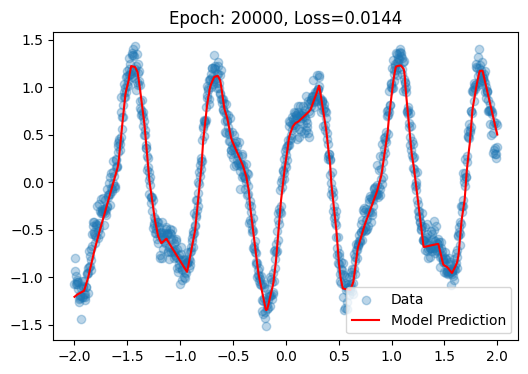

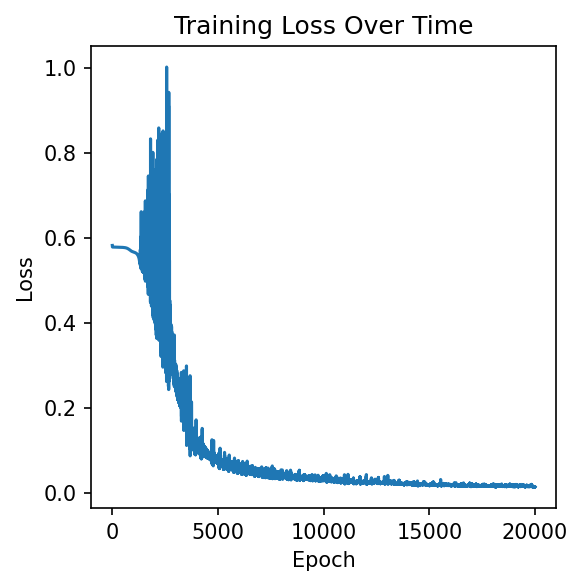

MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [102]:
train(MLP(), X_wav, Y_wav, epochs=20000, viz_every=100, learning_rate=0.1)